# Uma análise do mercado Segurador brasileiro

## Perguntas referencia
1. Crescimento entre seguradoras por premio ganho e emitido
2. top premio emitido
3. Market Share regra do link
4. Indice de Eficiencia : Despesa Administrativa/premio emitido
5. indice de sinistralidade: sinistros ocorridos / premio ganho
6. combined: sinistralidade + custo de aquisicao / premio ganho

## 1. Set up

Import some packages and the files I am goint to use.

In [92]:
#import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize']=(15,5)

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', None)

In [36]:
path = '/Users/Lucas/Sicoob/Produtos e Processos de Seguros - Documentos/GERENCIA DE PROCESSOS E PRODUTOS/3. NÚCLEO DE INFORMAÇÕES GERENCIAIS/Estudos/Mercado Segurador/SES-SUSEP/'

#income statments sheet
companiesData = pd.read_csv(path+'SES_Balanco.csv', ';',decimal =',',dtype={'valor': np.float64})

#companies
companies = pd.read_csv(path+'SES_cias.csv', ';',encoding='latin-1')

#encode for the income statments base fields 
fields = pd.read_csv(path+'SES_campos.csv', ';',encoding='latin-1')

#values of prize by branch
dataBybranch = pd.read_csv(path+'Ses_seguros.csv', ';',encoding='latin-1')

#comanies holdings
comanies_holdings = pd.read_csv(path+'Ses_grupos_economicos.csv', ';',encoding='latin-1')

foresight = pd.read_csv(path+'Ses_Contrib_Benef.csv',';',encoding='latin-1')

/Users/Lucas/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 2. Exploratory analysis

I am going to do a Exploratory analysis over the bases I imported. Important statments:
 - The fields base has a end of term column. The last end of term is 210001 which stand for year 2020 and month 01 (janary)
 - the income_statmente has only one field tha should be of type float, which is 'values'
 - the income_statment is showing the cumulative sum of the values of each field
 - the are some Nan values in the premium dataset. 


In [4]:
#income_statment.info()
#companies.head()
#fields.fimvigencia.unique()
#fields.info()
#max(set(fields.fimvigencia)) ## 201906
#fields[fields.noitem.str.contains(regex=True,pat='(Donativos e Contribuições)')].nuitem.unique()
#company_goup.head()
foresight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22061 entries, 0 to 22060
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   coenti    22061 non-null  int64 
 1   damesano  22061 non-null  int64 
 2   tipoProd  22061 non-null  object
 3   contrib   22061 non-null  object
 4   benef     22061 non-null  object
dtypes: int64(2), object(3)
memory usage: 861.9+ KB


## 3. Clean the base

The premium base is the core of our dataset and holds several importate rubrics for our analysis separated by branch. It has the following columns of interest:
    - damesano: year-month 202005
    - coenti: companies code
    - cogrupo: insurancer holding
    - coramo: branch's code :first 2 digits are the branch group and the last 2 are the specific branch
    - premio_emitido2: the premium 
    - premio_ganho: Earned Premium, according to the National Insurance brokers association (NIBA) glossary:
        
        "Insurance policies usually run for a period of 12 months. An insured
         can cancel a policy at any time and request a refund of premium.
         Therefore, insurers must only take into the books of account that
         portion of premium which corresponds to actual elapsed time on risk.
         That portion of premium which can be taken up in the accounts is
         called earned premium. That portion of premium yet to expire is"
        
    - sinistro_ocorrido: insurances claimed
    - desp_com: comercial expanses, like comission

I'll start separating 1 column for all the branches that a company work and another column for just the life branches. 

For life branch's we need to filter the first two coramo digits to 9,13 and only the full 'coramo' code 1198. The code 1198 is a specific branch called "farmer's life insurance". By some reason, not in the regular branches 9 and 13.

In all the dataset's, when possible, I selected the dates after december 2016 (201612).


In [10]:
premium = dataBybranch.copy()

premium['damesano'] = pd.to_datetime(premium['damesano'],format='%Y%m')
premium = premium[premium.damesano.dt.year>2016]
cols = premium.columns[premium.dtypes.eq('object')]
#since brazilian deciamal separator is represented by ',', i need to change all the , by . to peform to_nuemric
premium[cols] = premium[cols].replace('(,)','.',regex=True)
#some of the data have mix negative positive values when it should all be positive, so i use the .abs()
premium[cols] = premium[cols].apply(pd.to_numeric, errors='coerce').abs() 

#there are few nan values in the dataset. There are no big disadvantages in replacing it for 0's
premium.fillna(0,inplace=True)

#aggregate the values for year and company
life_premium = premium[(premium.coramo.astype(int).astype(str).str[:-2].astype(int).isin([9,13])) 
                  | (premium.coramo==1198) ].groupby(['coenti','damesano']).sum().reset_index() 
all_premium = premium.groupby(['coenti','damesano']).sum().reset_index()[['coenti','damesano','premio_emitido2']]

premium_comparison = life_premium.merge(all_premium
                                        ,left_on=['coenti','damesano']
                                        ,right_on=['coenti','damesano']
                                        ,suffixes=['_life','_all'])

keep_columns = ['coenti','damesano','premio_emitido2_life','premio_emitido2_all','premio_ganho','sinistro_ocorrido','desp_com']
premium_comparison = premium_comparison.filter(keep_columns,axis=1)

#keep_columns = ['premio_emitido2_life','premio_emitido2_all','premio_ganho','sinistro_ocorrido','desp_com']
#cum_sum_columns = ["CUM_premio_emitido2_life","CUM_premio_emitido2_all","CUM_premio_ganho","CUM_sinistro_ocorrido","CUM_desp_com"]
#premium_comparison[cum_sum_columns] = premium_comparison[keep_columns].sort_values('damesano').groupby(['coenti','damesano']).cumsum()

#change names for easy understanding
premium_comparison.rename(columns={
    "premio_emitido2_life":"premium_life",
    "premio_emitido2_all": "premium_all",
    "premio_ganho": "earned_life_premium",
    "sinistro_ocorrido": "insurance_claimed",
    "desp_com":"comercial_expanses"},
    inplace=True)


premium_comparison.head()


,coenti,damesano,premium_life,premium_all,earned_life_premium,insurance_claimed,comercial_expanses
0,1007,2017-01-01,10550016.51,15306550.23,10581494.19,234326.34,2346595.00
1,1007,2017-02-01,10500241.57,13113736.91,10526712.73,1031894.16,2422182.27
2,1007,2017-03-01,14577912.72,17091306.44,11326174.28,513454.34,2218428.61
3,1007,2017-04-01,14082756.03,16057999.36,14401689.24,221257.18,2316204.26
4,1007,2017-05-01,12902987.98,15019202.57,13230197.73,850923.47,2452322.89


The forsight dataset is for acessing the forsight data which has a special ensurance type. The columns avalibe are:
    - coenti
    - noenti
    - tipoProd: product type. We want the "PrevTrad" which stands by traditional foresight
    - contrib: premium
    - benef: insuranced claimed

In [6]:
risk_data = foresight[foresight.tipoProd=='PrevTrad']

risk_data['damesano'] = pd.to_datetime(risk_data['damesano'],format='%Y%m')
risk_data = risk_data[risk_data.damesano.dt.year>2016]

risk_data[['contrib','benef']] = risk_data[['contrib','benef']].replace('(,)','.',regex=True).apply(pd.to_numeric, errors='coerce').abs() 
risk_data.drop('tipoProd',axis=1,inplace=True)
risk_data.head()


/Users/Lucas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,coenti,damesano,contrib,benef
17,10707,2018-12-01,1160557.23,696094.35
19,6033,2019-09-01,3300143.69,1417532.53
44,10901,2018-03-01,653373.46,172945.21
53,11088,2018-02-01,9772.00,22430.44
68,5070,2020-03-01,3659705.73,280990.91


The income_statmente dataset contains:
    - coenti: companies code
    - damesano: year-month 2020-05
    - cmpid: field code in the income_statment
    - valor: values
    - seq: order of the field in the income_statment
    - quadro: type of accounting statement
    

For the income_statment base I filter the column 'quadro' to bring onlt the ones with ' 23' because this the code for the sheet of the income statment. Also, I filtered only the rubrics we need for the analyses:
 - 4069: that is the administrative expense (ae)
 - 6314: employee expenses 
 - 6315: third-party spending
 - 6317: publicity
 - 6319: donations
 
One special note about this dataset is that it is all in cumulative values.

In [71]:
income_statment = companiesData.copy()
income_statment = income_statment[(income_statment['damesano']>201612) &
                                  (income_statment['quadro'] == '23 ') &
                                  (income_statment.cmpid.isin([4069,6314,6315,6319]))
                                 ] 
income_statment.valor = income_statment.valor.abs()

# I prefered to work with the income_statment in wide format rather then long, so I converted the data frame.
income_statment = pd.pivot_table(income_statment, index=['coenti','damesano'],columns='cmpid', values='valor').rename_axis(None, axis=1).reset_index()
income_statment.rename(columns={4069: "ae",
                6314: "ae_employee",
                6315: "ae_3pspending",
                6317: "ae_publicity",
                6319: "ae_donations"}
       ,inplace=True )

#filtering the last period of each year
income_statment ['damesano'] = pd.to_datetime(income_statment['damesano'],format='%Y%m')
income_statment['year'] = income_statment.damesano.dt.year

#tranforming the cumulative values into monthly values
income_statment_monthly = income_statment.groupby(['coenti','year']).diff().fillna(income_statment).drop('damesano',axis=1)
income_statment = pd.concat([income_statment[['coenti','damesano']],income_statment_monthly],axis=1)


#income_statment.drop('damesano',axis=1,inplace=True)
income_statment.head()


,coenti,damesano,ae,ae_employee,ae_3pspending,ae_donations
0,1007,2017-01-01,4947532.98,1958772.56,1972618.04,1331.00
1,1007,2017-02-01,5401444.50,2569637.31,1725811.30,3174.91
2,1007,2017-03-01,5788573.83,2472183.39,2048791.62,10664.24
3,1007,2017-04-01,5696591.72,2418506.34,2015451.60,44257.98
4,1007,2017-05-01,4823307.94,2275595.80,1750132.81,113164.42


The company_group dataset contains:
    - coenti
    - damesano: year-month of that group info to the company
    - noenti: name of company
    - cogrupo: code of company group
    - nogrupo: name of company group

In [37]:
company_goup = comanies_holdings.copy()

#chosing only the latest group names
company_goup_key = company_goup.groupby('coenti').max().reset_index()[['coenti','damesano']]
company_goup = company_goup.merge(company_goup_key,how='inner',left_on=['coenti','damesano'],right_on=['coenti','damesano'])

#if the group is independent
company_goup.nogrupo = np.where(company_goup.cogrupo.isin(['1225','99999']),
                                company_goup.noenti.str.strip(),
                                company_goup.nogrupo.str.strip())
company_goup = company_goup[['coenti','nogrupo']]

#this comapnies belong to the same group but they weren't grouped. I'll do it manualy 
company_goup.replace(['Zurich Santander Brasil Seguros e Previdencia S/A','ZURICH BRASIL COMPANHIA DE SEGUROS'],
                     'ZURICH',
                     inplace=True)

company_goup.head()

,coenti,nogrupo
0,5061,MERIDIONAL
1,6858,MAPFRE AFFINITY SEGURADORA S.A.
2,77721,Benfield do Brasil Corretora de Resseguros Ltda.
3,20281,HORIZONTE CAPITALIZAÇÃO S/A
4,4871,VOTORANTIM SEGUROS E PREVIDÊNCIA S.A


In [80]:
#combinig the data sets
final_dataset = company_goup.merge(premium_comparison,left_on='coenti',right_on='coenti')
final_dataset = final_dataset.merge(risk_data,left_on=['coenti','damesano'],right_on=['coenti','damesano'],how='left') 
final_dataset = final_dataset.merge(income_statment,left_on=['coenti','damesano'],right_on=['coenti','damesano'])

final_dataset.head()

,coenti,nogrupo,damesano,premium_life,premium_all,earned_life_premium,insurance_claimed,comercial_expanses,contrib,benef,ae,ae_employee,ae_3pspending,ae_donations
0,6220,SUL AMERICA,2017-01-01,31459636.37,31459636.37,36168882.24,18309246.22,10174681.28,4203735.14,4786730.72,9078025.91,2080355.68,5676783.17,4050.29
1,6220,SUL AMERICA,2017-02-01,31116285.24,31116285.24,35295366.24,21259966.08,9751599.99,3455455.12,5018101.34,9246185.59,3058936.33,5314535.42,5049.99
2,6220,SUL AMERICA,2017-03-01,34471430.13,34471430.13,36587923.00,12523930.89,10539065.70,5184190.68,7973820.66,10338874.20,3389598.69,5507295.06,5049.99
3,6220,SUL AMERICA,2017-04-01,33466474.32,33466474.32,35667234.88,17473838.93,9976480.99,3964834.52,5289016.05,8292220.03,2320432.94,6141135.16,5049.99
4,6220,SUL AMERICA,2017-05-01,38297913.60,38297913.60,35769344.96,23071867.06,10542046.32,4235829.76,6675468.59,7147856.90,2180417.77,4308123.57,7617.69


## 4. Creating KPI's 

Some important indicators in the insurance business are: 
- Operetional Eficiency Indicator adminstative expanses / premium;
- Loss ratio insurance_claimed / premium;
- Combined (comercial_expanses + insurance_claimed) /premium

Since the adminstative expanses are informed in the income statment for the whole operation of each company, I will use the proportional expanses of the life branch in order to calculate the EIO.

In [86]:
final_dataset.premium_life = final_dataset.premium_life + final_dataset.contrib
final_dataset.premium_all = final_dataset.premium_all + final_dataset.contrib
final_dataset.insurance_claimed = final_dataset.insurance_claimed + final_dataset.benef

#ae_proportion = final_dataset.premium_life/final_dataset.premium_all
#final_dataset['OEI'] = -final_dataset.ae * ae_proportion / final_dataset.premium_life
final_dataset['loss_ratio'] = final_dataset.insurance_claimed / final_dataset.premium_life
final_dataset['combined'] = (final_dataset.comercial_expanses + final_dataset.insurance_claimed) / final_dataset.premium_life

final_dataset = final_dataset.sort_values(['coenti','damesano'])
final_dataset['pct'] = final_dataset.groupby(['coenti','nogrupo']).apply(lambda x: x['premium_life'].pct_change()).values

final_dataset.head()

,coenti,nogrupo,damesano,premium_life,premium_all,earned_life_premium,insurance_claimed,comercial_expanses,contrib,benef,loss_ratio,combined,pct
770,1007,SABEMI SEGURADORA SA,2017-01-01,11698588.17,16455121.89,10581494.19,544608.24,2346595.00,1148571.66,310281.90,0.05,0.25,nan
771,1007,SABEMI SEGURADORA SA,2017-02-01,11685755.18,14299250.52,10526712.73,1172396.45,2422182.27,1185513.61,140502.29,0.10,0.31,-0.00
772,1007,SABEMI SEGURADORA SA,2017-03-01,15827305.89,18340699.61,11326174.28,916450.02,2218428.61,1249393.17,402995.68,0.06,0.20,0.35
773,1007,SABEMI SEGURADORA SA,2017-04-01,15360325.56,17335568.89,14401689.24,373645.72,2316204.26,1277569.53,152388.54,0.02,0.18,-0.03
774,1007,SABEMI SEGURADORA SA,2017-05-01,14190937.51,16307152.10,13230197.73,1163791.47,2452322.89,1287949.53,312868.00,0.08,0.25,-0.08


In [42]:
final_dataset.head()

,coenti,damesano,premium_life,premium_all,earned_life_premium,insurance_claimed,comercial_expanses,ae,ae_employee,ae_3pspending,ae_donations
0,1007,2017-01-01,10550016.51,15306550.23,10581494.19,234326.34,2346595.00,-4947532.98,-1958772.56,-1972618.04,-1331.00
1,1007,2017-02-01,10500241.57,13113736.91,10526712.73,1031894.16,2422182.27,-5401444.50,-2569637.31,-1725811.30,-3174.91
2,1007,2017-03-01,14577912.72,17091306.44,11326174.28,513454.34,2218428.61,-5788573.83,-2472183.39,-2048791.62,-10664.24
3,1007,2017-04-01,14082756.03,16057999.36,14401689.24,221257.18,2316204.26,-5696591.72,-2418506.34,-2015451.60,-44257.98
4,1007,2017-05-01,12902987.98,15019202.57,13230197.73,850923.47,2452322.89,-4823307.94,-2275595.80,-1750132.81,-113164.42


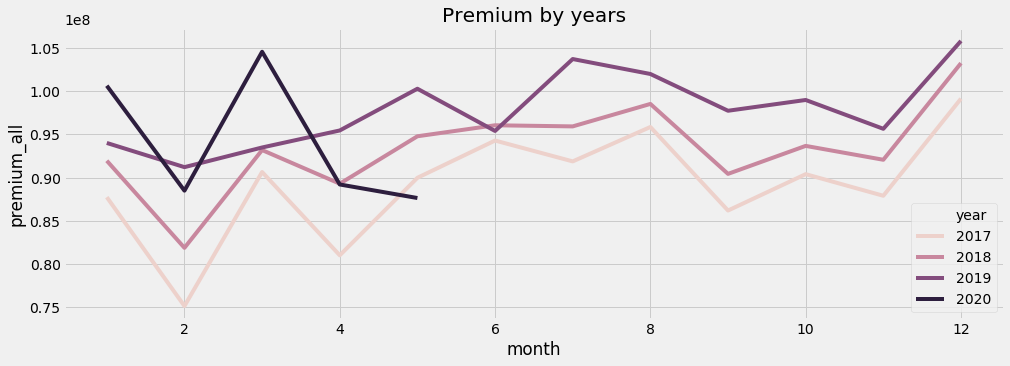

In [106]:
pre = final_dataset.groupby(final_dataset.damesano).mean().reset_index()
pre['year'] = pre.damesano.dt.year
pre['month'] = pre.damesano.dt.month

ax = sns.lineplot(x="month", y="premium_all", hue="year",markers=True,dashes=False,data=pre)
ax.set_title("Premium by years")

plt.savefig('/Users/Lucas/Desktop/premio_anos.jpeg')

Text(0.5, 1.0, 'Life Premium by years')

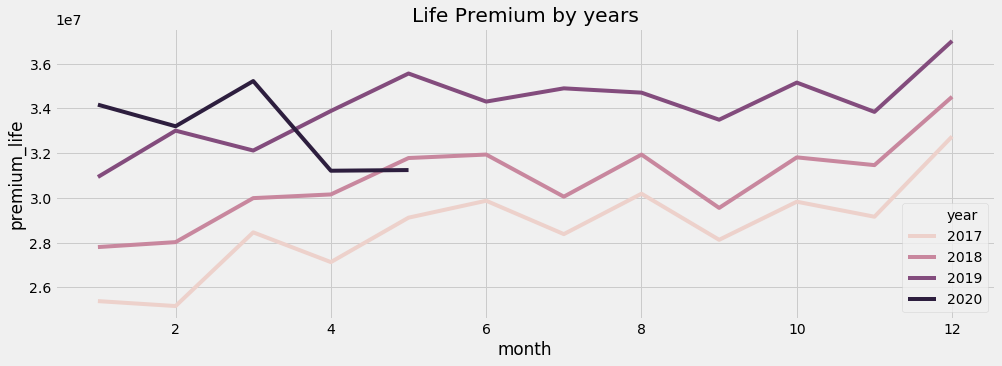

In [107]:
ax = sns.lineplot(x="month", y="premium_life", hue="year",markers=True,dashes=False,data=pre)
ax.set_title("Life Premium by years")

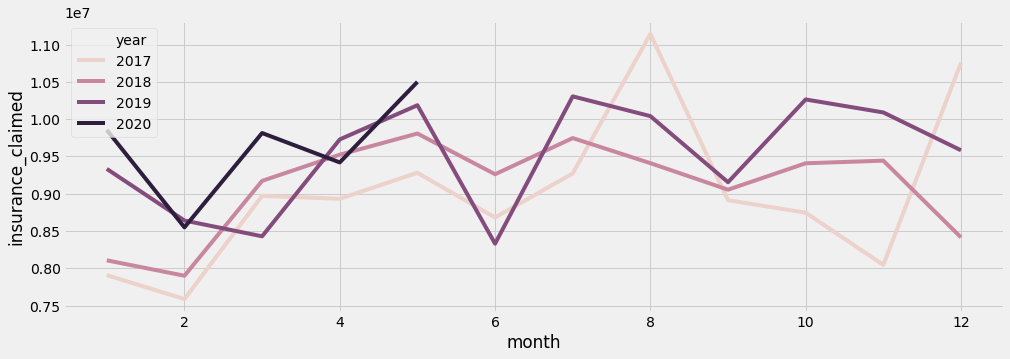

In [98]:
sns.lineplot(x="month", y="insurance_claimed", hue="year",markers=True,dashes=False,data=pre)


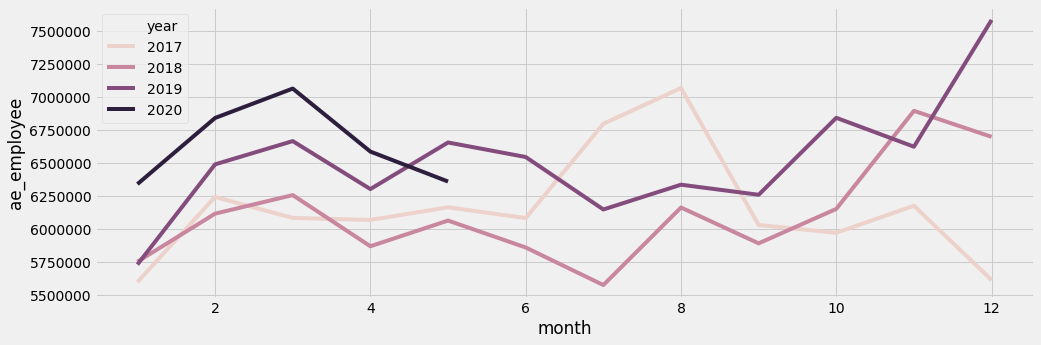

In [99]:
sns.lineplot(x="month", y="ae_employee", hue="year",markers=True,dashes=False,data=pre)


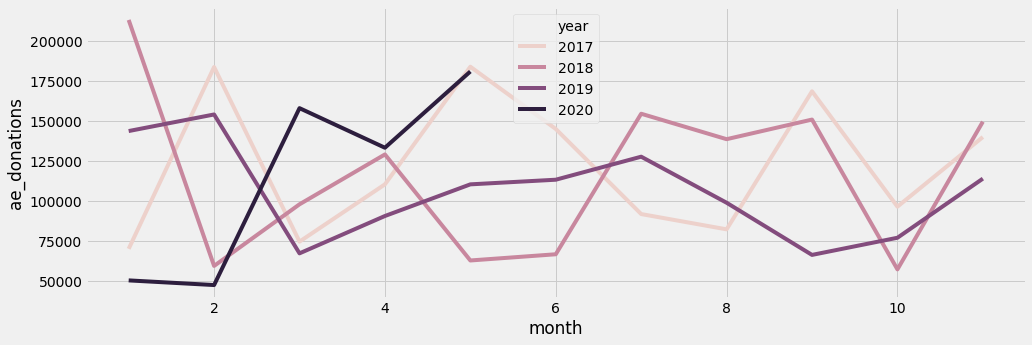

In [101]:
sns.lineplot(x="month", y="ae_donations", hue="year",markers=True,dashes=False,data=pre[pre.month!=12])